### Import Modules

In [4]:
!pip install xlrd
import numpy as np
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
from scipy import stats


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 103 kB 187 kB/s eta 0:00:01
You should consider upgrading via the '/snap/jupyter/6/bin/python -m pip install --upgrade pip' command.


### Loading Dateset

In [5]:
data = pd.read_excel("Online Retail.xlsx")

### Analysing Data

In [6]:
data.head()

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
data.tail()

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,NaN,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,NaN,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,NaN,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,NaN,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,NaN,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   lower        1816 non-null    object        
 3   Description  540455 non-null  object        
 4   Quantity     541909 non-null  int64         
 5   InvoiceDate  541909 non-null  datetime64[ns]
 6   UnitPrice    541909 non-null  float64       
 7   CustomerID   406829 non-null  float64       
 8   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 37.2+ MB


#### Removing "lower" Column

In [9]:
del data["lower"]

#### Removing Null Rows 

In [10]:
data = data[pd.notnull(data['CustomerID'])]

#### Removing Duplicates

In [11]:
filtered_data  = data[['Country', 'CustomerID']].drop_duplicates()

#### Data Insights

<AxesSubplot:>

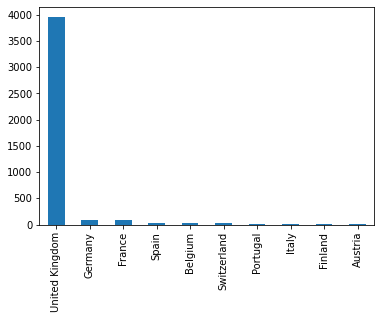

In [12]:
#Top ten country's customer
filtered_data.Country.value_counts()[:10].plot(kind='bar')


In [13]:
uk_data = data[data.Country == 'United Kingdom']

In [14]:
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361878 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    361878 non-null  object        
 1   StockCode    361878 non-null  object        
 2   Description  361878 non-null  object        
 3   Quantity     361878 non-null  int64         
 4   InvoiceDate  361878 non-null  datetime64[ns]
 5   UnitPrice    361878 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      361878 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB


In [15]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


Filtering out rows with Negative Quantity Value

In [16]:
uk_data = uk_data[(uk_data['Quantity']>0)]

Filtering Required Columns

In [17]:
uk_data = uk_data[['CustomerID', 'InvoiceDate', 'InvoiceNo', 'Quantity', 'UnitPrice']]


In [18]:
uk_data['TotalPrice'] = uk_data['Quantity'] * uk_data['UnitPrice']


In [19]:
uk_data['InvoiceDate'].min(), uk_data['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [20]:
PRESENT = dt.datetime(2011, 12, 10)

In [21]:
uk_data['InvoiceDate'] = pd.to_datetime(uk_data['InvoiceDate'])

In [22]:
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


### RFM Analysis

RFM analysis is a data-driven customer behavior segmentation technique where RFM stands for recency, frequency, and monetary value.
Recency : When their last purchase was.
Frequency : How often they've purchased in the past
Monetary : How much have they spent


In [ ]:
rfm = uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                         'InvoiceNo': lambda num: len(num),
                                         'TotalPrice': lambda price: price.sum()})

In [ ]:
rfm.columns


In [ ]:
# Change the names of the columns
rfm.columns=['recency','frequency','monetary'] 

In [ ]:
rfm['recency'] = rfm['recency'].astype(int)

In [ ]:
rfm.head()

In [ ]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

In [ ]:
rfm.head()

### RFM Result Interpretation

In [ ]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()


In [ ]:
# Filter out Top/Best cusotmers
rfm[rfm['RFM_Score']=='111'].sort_values('monetary', ascending=False).head()

### Manage Skewness and Scaling

In [ ]:
rfm['recency'].hist()

In [ ]:
rfm['frequency'].hist()

In [ ]:
rfm['monetary'].hist()

In [ ]:
rfm = rfm[rfm['recency'] > 0]

To make the data more normal (i.e: bell-shaped), we can apply box-cox transformation. https://www.statisticshowto.com/box-cox-transformation/

In [ ]:
rfm_fix = pd.DataFrame()
rfm_fix["Recency"] = stats.boxcox(rfm['recency'])[0]
rfm_fix["Frequency"] = stats.boxcox(rfm['frequency'])[0]
rfm_fix["Monetary"] = pd.Series(np.cbrt(rfm['monetary'])).values

In [ ]:
rfm_fix.tail()

In [1]:
rfm_fix['recency'].hist()

NameError: name 'rfm_fix' is not defined

#### Standarize the RFM

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(rfm_fix)
rfm_normalized = scaler.transform(rfm_fix)


In [61]:
print(rfm_normalized.mean(axis = 0).round(2))

[-0. -0. -0.]


In [62]:
print(rfm_normalized.std(axis = 0).round(2))

[1. 1. 1.]


In [63]:
rfm_normalized

array([[ 1.62602271, -2.511996  ,  7.30566313],
       [-1.81806299,  0.724934  ,  1.44380485],
       [-1.6455989 ,  1.2622111 ,  1.41369633],
       ...,
       [-1.24114333, -0.88845318, -0.88415926],
       [-1.6455989 ,  2.41832941,  0.70490608],
       [-0.1486117 ,  0.4195582 ,  0.58354438]])

### Modelling

In [65]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k ,random_state=42)
  kmeans.fit(rfm_normalized)
  sse[k] = kmeans.inertia_


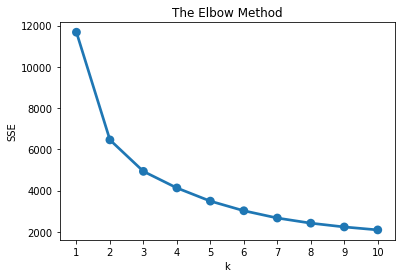

In [66]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show()

According to Elbow Method, we choose the value of k just right where the slope starts becoming linear. Since from k=3 onwards, slope starts to become almost linear, so we select the number of clusters to be k=3.

In [69]:
model = KMeans(n_clusters = 3, random_state=42)
model.fit(rfm_normalized)
model.labels_

array([1, 1, 1, ..., 2, 1, 2], dtype=int32)

### Interpreting the Segmented Customers

In [73]:
rfm["Cluster"] = model.labels_
rfm.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency' : 'mean',
    'monetary' : ['mean' , 'count']}).round(2)

recency frequency monetary      
           mean      mean     mean count
Cluster                                 
0        182.71     19.30   366.42  1496
1         21.40    287.82  6286.29   704
2         42.08     65.14   961.65  1693

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


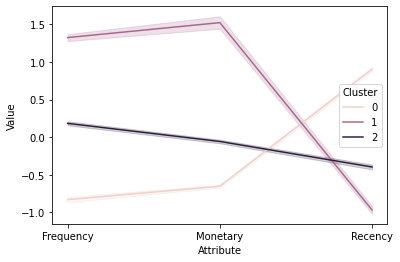

In [75]:
# Create the dataframe
df_normalized = pd.DataFrame(rfm_normalized, columns=
                             ['Recency', 'Frequency', 'Monetary'])
df_normalized['ID'] = rfm.index
df_normalized['Cluster'] = model.labels_

# Melt the data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=
                      [ 'Frequency', 'Monetary', 'Recency'],
                      var_name='Attribute',
                      value_name = 'Value')
df_nor_melt.head()

# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt, labels)

### Interpretation

**Cluster-0** bought the products long time ago, have low shopping frequency and spent less money. Therefore these could be ***churned customers***.

**Cluster-1** bought products frequently and spend more, and they bought goods recently .Therefore, this cluster could indicate the ***loyal customers***.

**Cluster-2** bought products less frequently, spend less money but they bought products just recently. Therefore, this cluster could be ***new customers***. 

### Conclusion
RFM technique is a proven marketing model that helps retailers and e-commerce businesses maximize the return on their marketing investments.
The above-generated RFM customer segments can be easily used to identify high ROI segments and engage them with personalized offers.